## Syntactic Processing Assignment

### 1. Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# printing first 10 tagged sentences
print(nltk_data[:5])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

##### Lets sample the dataset into training and validation dataset in ratio of 95:5  

In [4]:
# Randomly splitting dataset into train and test set
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:5])

3718
196
[[('This', 'DET'), ('cute', 'ADJ'), ('child', 'NOUN'), ('turns', 'VERB'), ('out', 'PRT'), ('*-1', 'X'), ('to', 'PRT'), ('be', 'VERB'), ('a', 'DET'), ('blessing', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('curse', 'NOUN'), ('.', '.')], [('For', 'ADP'), ('example', 'NOUN'), (',', '.'), ('there', 'DET'), ('are', 'VERB'), ('options', 'NOUN'), ('on', 'ADP'), ('the', 'DET'), ('S&P', 'NOUN'), ('500', 'NUM'), ('futures', 'NOUN'), ('contract', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('the', 'DET'), ('S&P', 'NOUN'), ('100', 'NUM'), ('index', 'NOUN'), ('.', '.')], [('A', 'DET'), ('survey', 'NOUN'), ('by', 'ADP'), ('the', 'DET'), ('Federal', 'NOUN'), ('Reserve', 'NOUN'), ("'s", 'PRT'), ('12', 'NUM'), ('district', 'NOUN'), ('banks', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('latest', 'ADJ'), ('report', 'NOUN'), ('by', 'ADP'), ('the', 'DET'), ('National', 'NOUN'), ('Association', 'NOUN'), ('of', 'ADP'), ('Purchasing', 'NOUN'), ('Management', 'NOUN'), ('blurred', 'VERB'), ('that', 'DET'), (

We can see total num of sentences in train set are **3718**.
and total num on sentences in test set are **196**.

In [5]:
# Getting list of tagged words or tupels in the training set
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95354

In [6]:
# printing first 10 tokens in the training set 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['This', 'cute', 'child', 'turns', 'out', '*-1', 'to', 'be', 'a', 'blessing']

In [7]:
# vocabulary
V = set(tokens)
#Total num of unique tokens/words in the training dataset
print(len(V))

12064


In [8]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

There are **12** diffrent tags used.

In [9]:
#Printing the 12 different tags
print(T)

{'PRON', '.', 'ADV', 'DET', 'ADP', 'NUM', 'X', 'ADJ', 'VERB', 'NOUN', 'CONJ', 'PRT'}


## 2. POS Tagging Algorithm

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a JJ, then t(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 



### Emission Probabilities

In [10]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [11]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

### Transition Probabilities

In [12]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [13]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [14]:
tags_matrix

array([[7.70712923e-03, 4.12331410e-02, 3.35260108e-02, 1.00192679e-02,
        2.31213868e-02, 7.32177263e-03, 9.24855471e-02, 7.36030862e-02,
        4.85163778e-01, 2.08863199e-01, 5.00963395e-03, 1.19460505e-02],
       [6.59002438e-02, 9.17896256e-02, 5.34986891e-02, 1.74889117e-01,
        9.08844024e-02, 8.08364227e-02, 2.75187828e-02, 4.47180234e-02,
        8.97076130e-02, 2.19516605e-01, 5.84774129e-02, 2.17253552e-03],
       [1.59574468e-02, 1.36635631e-01, 7.94547871e-02, 6.74867034e-02,
        1.18351065e-01, 3.32446806e-02, 2.29388289e-02, 1.31316483e-01,
        3.41422886e-01, 3.19148935e-02, 6.98138308e-03, 1.42952129e-02],
       [3.74350930e-03, 1.82345118e-02, 1.23173529e-02, 5.67564322e-03,
        9.41915251e-03, 2.29440890e-02, 4.55259010e-02, 2.03840122e-01,
        4.06955667e-02, 6.36879623e-01, 4.83033451e-04, 2.41516726e-04],
       [6.87153190e-02, 3.92658971e-02, 1.34443026e-02, 3.23623568e-01,
        1.68587286e-02, 6.31668791e-02, 3.42509598e-02, 1.07

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [16]:
tags_df

,PRON,.,ADV,DET,ADP,NUM,X,ADJ,VERB,NOUN,CONJ,PRT
PRON,0.007707,0.041233,0.033526,0.010019,0.023121,0.007322,0.092486,0.073603,0.485164,0.208863,0.005010,0.011946
.,0.065900,0.091790,0.053499,0.174889,0.090884,0.080836,0.027519,0.044718,0.089708,0.219517,0.058477,0.002173
ADV,0.015957,0.136636,0.079455,0.067487,0.118351,0.033245,0.022939,0.131316,0.341423,0.031915,0.006981,0.014295
DET,0.003744,0.018235,0.012317,0.005676,0.009419,0.022944,0.045526,0.203840,0.040696,0.636880,0.000483,0.000242
ADP,0.068715,0.039266,0.013444,0.323624,0.016859,0.063167,0.034251,0.107554,0.008643,0.322236,0.000747,0.001494
NUM,0.001480,0.117821,0.002664,0.003552,0.035228,0.185613,0.206631,0.034340,0.017466,0.354056,0.013914,0.027235
X,0.055733,0.164324,0.025551,0.054136,0.145321,0.002555,0.075056,0.016927,0.206484,0.060683,0.009582,0.183647
ADJ,0.000657,0.065078,0.004601,0.004930,0.078061,0.020214,0.021364,0.066886,0.011832,0.698110,0.017256,0.011011
VERB,0.035273,0.034807,0.082356,0.134100,0.091290,0.022531,0.217543,0.065807,0.168674,0.111336,0.005206,0.031078
NOUN,0.004876,0.238938,0.016679,0.013490,0.178159,0.009568,0.029070,0.012024,0.147696,0.263023,0.042377,0.044100


In [17]:
tags_df.loc['.', :]

PRON    0.065900
.       0.091790
ADV     0.053499
DET     0.174889
ADP     0.090884
NUM     0.080836
X       0.027519
ADJ     0.044718
VERB    0.089708
NOUN    0.219517
CONJ    0.058477
PRT     0.002173
Name: ., dtype: float32

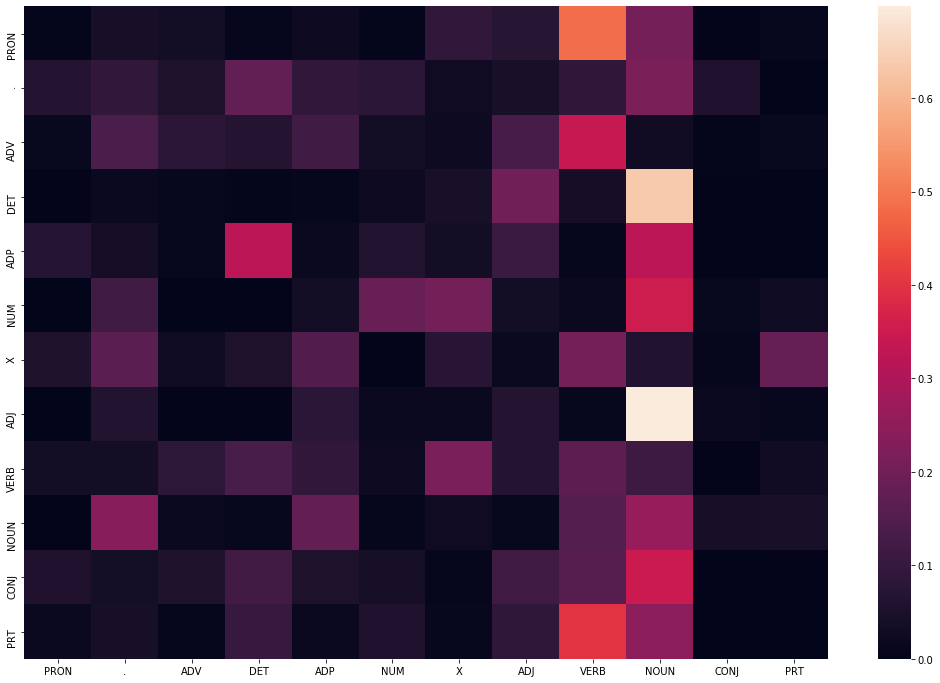

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

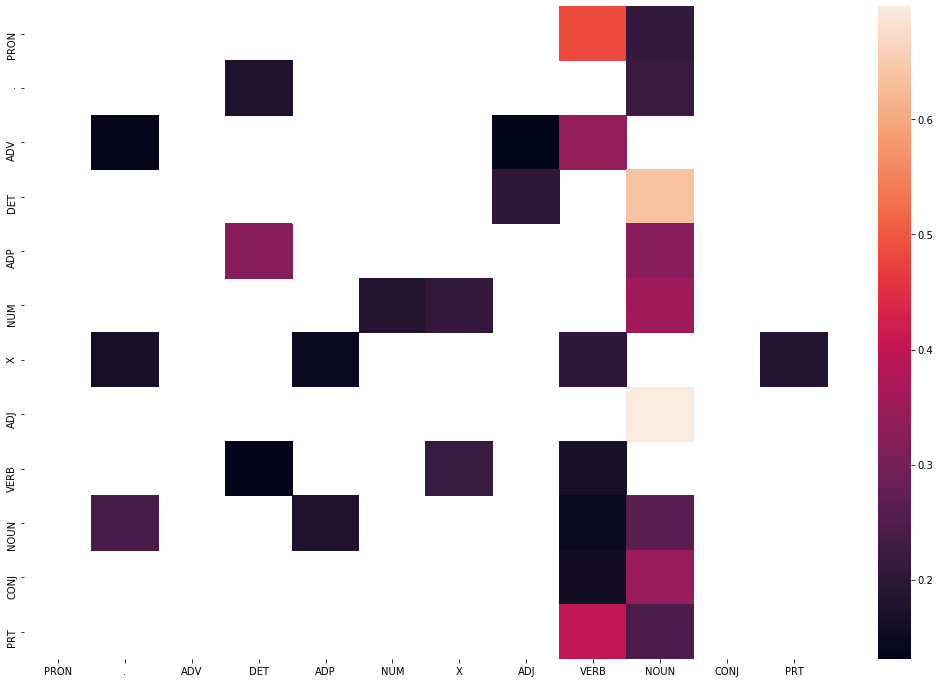

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.125]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

## 3. Vanilla Viterbi Algorithm 

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [20]:
#Print total set of tagged words
len(train_tagged_words)

95354

In [21]:
# Viterbi Heuristic
def Vanilla_Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

####  Evaluating on Test Set

In [23]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
#rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
#test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]

In [24]:
# tagging the test sentences
start = time.time()
tagged_seq = Vanilla_Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [25]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  1087.0427675247192
[('The', 'DET'), ('move', 'NOUN'), ('is', 'VERB'), ('part', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('strategy', 'NOUN'), ('0', 'X'), ('*T*-3', 'X'), ('to', 'PRT'), ('focus', 'VERB'), ('on', 'ADP'), ('its', 'PRON'), ('core', 'NOUN'), ('metals', 'NOUN'), ('trading', 'NOUN'), (',', '.'), ('processing', 'NOUN'), ('and', 'CONJ'), ('plant', 'NOUN'), ('engineering', 'NOUN'), ('activities', 'NOUN'), ('while', 'ADP'), ('*-1', 'X'), ('shedding', 'PRON'), ('peripheral', 'ADJ'), ('units', 'NOUN'), (',', '.'), ('the', 'DET'), ('company', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), ('.', '.'), ('The', 'DET'), ('limits', 'NOUN'), ('to', 'PRT'), ('legal', 'ADJ'), ('absurdity', 'PRON'), ('stretched', 'PRON'), ('another', 'DET'), ('notch', 'PRON'), ('this', 'DET'), ('week', 'NOUN'), ('when', 'ADV'), ('the', 'DET'), ('Supreme', 'NOUN'), ('Court', 'NOUN'), ('refused', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('hear', 'VERB'), ('an', 'DET'), ('appeal', 'NOU

In [26]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_vanilla_viterbi = len(check)/len(tagged_seq)
accuracy_vanilla_viterbi

0.9075535512965051

In [27]:
#Let's have look at incorrect tagged cases
incorrect_tagged_vanilla_viterbi = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_vanilla_viterbi

[[('*-1', 'X'), (('shedding', 'PRON'), ('shedding', 'VERB'))],
 [('legal', 'ADJ'), (('absurdity', 'PRON'), ('absurdity', 'NOUN'))],
 [('absurdity', 'NOUN'), (('stretched', 'PRON'), ('stretched', 'VERB'))],
 [('another', 'DET'), (('notch', 'PRON'), ('notch', 'NOUN'))],
 [('case', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('and', 'CONJ'), (('that', 'DET'), ('that', 'ADP'))],
 [('are', 'VERB'), (('performing', 'PRON'), ('performing', 'VERB'))],
 [('morphogenetic', 'ADJ'), (('protein', 'PRON'), ('protein', 'NOUN'))],
 [('unusual', 'ADJ'), (('write-downs', 'PRON'), ('write-downs', 'NOUN'))],
 [('$', '.'), (('4.9', 'PRON'), ('4.9', 'NUM'))],
 [('exports', 'NOUN'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('under', 'ADP'), (('more', 'ADJ'), ('more', 'ADV'))],
 [('.', '.'), (('Tray', 'PRON'), ('Tray', 'NOUN'))],
 [('Tray', 'NOUN'), (('Bon', 'PRON'), ('Bon', 'NOUN'))],
 [("'s", 'PRT'), (('editions', 'PRON'), ('editions', 'NOUN'))],
 [('*EXP*-1', 'X'), (("'s", 'PRT'), ("'s", 'VERB'))],
 [('a

In [28]:
## Testing
sentence_test = 'Google and Twitter made a deal in 2015 that gave Google access to Twitter\'s firehose.'
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Vanilla_Viterbi(words)
end = time.time()
difference = end-start

In [29]:
print(tagged_seq)
print(difference)

[('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRON'), ("'s", 'VERB'), ('firehose', 'PRON'), ('.', '.')]
3.313976526260376


### 4. Solve the problem of unknown words

The default **Vanilla viterbi algorithm achieved an accuracy of about 90.75%**. This approx. **10% loss of accuracy** was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

Now lets see how we can minimize this loss by modifying the vanilla viterbi.


### Viterbi modification - Technique  1

If a word is not present in the training vocabulary (unknown word), its emission probability will be **0**. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the emission probability and only consider the transition probability.

The algorithm can be modified to deal the case as below - 


    If we encounter unknown word then
        then consider only the transition_p
    else
       then consider both the emission and transition probability

In [30]:
# Modified Viterbi Heuristic
def Vanilla_Viterbi_for_Unknown_Words(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            # modification to the original vanilla viterbi algorithm 
            # to consider unknown words
            if word not in V:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
                
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [31]:
# tagging the test sentences
unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(test_tagged_words)

# accuracy
unknown_word_check = [i for i, j in zip(unknown_word_tagged_seq, test_run_base) if i == j]

optimized_viterbi_accuracy = len(unknown_word_check)/len(unknown_word_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is -", optimized_viterbi_accuracy)

The accuracy of the Vanilla Viterbi Algorithm after modification to handle unknown words is - 0.9406238256294626


We see the modified viterbi algorithm **performs better** than the original vanilla viterbi algorithm. The modified viterbi achieves an accuracy of (approx.) **94.06%** comapred to **90.12%** of the vanilla viterbi.

Still there is a loss of approx. 6%. 

Now lets see if we can in reduce this loss further.


#### Let's try with some Lexicon and Rule-Based Models for POS Tagging.

#### Unigram Tagger

In [32]:
# Lexicon (or unigram tagger)
unigram_tagger = nltk.UnigramTagger(train_set)
accuracy_unigram_tagger = unigram_tagger.evaluate(test_set)
print(accuracy_unigram_tagger)

0.905674558436678


In [33]:
# specify patterns for tagging
# example from the NLTK book
patterns = [
    (r'.*ing$', 'VBG'),              # gerund
    (r'.*ed$', 'VBD'),               # past tense
    (r'.*es$', 'VBZ'),               # 3rd singular present
    (r'.*ould$', 'MD'),              # modals
    (r'.*\'s$', 'NN$'),              # possessive nouns
    (r'.*s$', 'NNS'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'CD'), # cardinal numbers
    (r'.*', 'NN')                    # nouns
]

In [34]:
# patterns for tagging using a rule based regex tagger -

patterns_new = [
    (r'^[aA-zZ].*[0-9]+','NOUN'),  # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*', 'NOUN'),    
    (r'.*ly$', 'ADV'),
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'), # modals
    (r'(The|the|A|a|An|an)$', 'DET'),
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), # adjective like 100-megabytes 237-Seats
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb
    (r'[0-9].?[,\/]?[0-9]*','NUM')# Numbers 
    ]

#### Unigram Tagger backoff with Regex

In [35]:
# rule based tagger
#rule_based_tagger = nltk.RegexpTagger(patterns)
rule_based_tagger = nltk.RegexpTagger(patterns_new)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

accuracy_lexicon_tagger = lexicon_tagger.evaluate(test_set)
print(accuracy_lexicon_tagger)

0.9389327320556182


#### Bigram Tagger backoff with lexicon_tagger(Unigram Tagger backoff with Regex)

In [36]:
# Bigram and Trigram tagger
bigram_tagger = nltk.BigramTagger(train_set,backoff=lexicon_tagger)
bigram_tagger.evaluate(test_set)
accuracy_bigram_tagger = bigram_tagger.evaluate(test_set)
print(accuracy_bigram_tagger)

0.943630214205186


#### Trigram Tagger backoff with bigram_tagger(Bigram Tagger backoff with lexicon_tagger(Unigram Tagger backoff with Regex))

In [37]:
trigram_tagger = nltk.TrigramTagger(train_set, backoff=bigram_tagger)
trigram_tagger.evaluate(test_set)
accuracy_trigram_tagger = trigram_tagger.evaluate(test_set)
print(accuracy_trigram_tagger)

0.9451334084930477


### Viterbi modification - Technique  2


We see that the Trigram Tagger backed up by the bigram tagger gives an accuracy of about 93.83%. Let's now try to modify the viterbi algorithm to use this trigram tagger as a back-off. 

When the viterbi algorithm is not able to tag an unknown word, it uses the rule-based tagger.

In [38]:
print(T)

{'PRON', '.', 'ADV', 'DET', 'ADP', 'NUM', 'X', 'ADJ', 'VERB', 'NOUN', 'CONJ', 'PRT'}


In [39]:
def trigram_tagger(word,train_set = train_set):
   
    patterns = [
    (r'[aA-zZ]+(ed|ing|es)$', 'VERB'), # Any word ending with 'ing' or 'ed' is a verb

    (r'.*ly$', 'ADV'),
        
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'),
    (r'.*able$', 'ADJ'), 
    (r'.*ful$', 'ADJ'),
    (r'.*ous$', 'ADJ'),
        
    (r'^[aA-zZ].*[0-9]+','NOUN'),     # Alpha Numeric
    (r'.*ness$', 'NOUN'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns - words ending with 's
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'.*ers$', 'NOUN'),              # eg.- kinderganteners, autobioghapgers
    (r'.*ment$', 'NOUN'),
    (r'.*town$', 'NOUN'),
        
    (r'^(0|([*|-|$].*))','X'), # Any special character combination
    (r'.*ould$', 'X'),
        
    (r'(The|the|A|a|An|an|That|that|This|this|Those|those|These|these)$', 'DET'), # That/this/these/those belong to the category of Demonstrative determiners
    (r'[0-9].?[,\/]?[0-9]*','NUM'), # Numbers 
        
    (r'.*', 'NOUN')
    ]
        
    regex_based_tagger = nltk.RegexpTagger(patterns)

    # trigram backed up by the regex tagger
    trigram_regex_tagger = nltk.TrigramTagger(train_set, backoff=regex_based_tagger)
    return trigram_regex_tagger.tag_sents([[(word)]])

In [40]:
# viterbi with handling for unknown words from trigram tagger
def Viterbi_With_Trigram_Tagger(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        # unknown words from trigram taggr
        if word not in tokens:
            unk_word_tag=trigram_tagger(word)
            for sent in unk_word_tag:
                for tup in sent:
                    state.append(tup[1])
        # rest remains same            
        else:            
            p = [] 
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            
            pmax = max(p)
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)
            
    return list(zip(words, state))

In [41]:
start = time.time()
tagged_seq = Viterbi_With_Trigram_Tagger(test_tagged_words)
end = time.time()
difference = end-start

In [42]:
print(tagged_seq)
print(difference)

[('The', 'DET'), ('move', 'NOUN'), ('is', 'VERB'), ('part', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('strategy', 'NOUN'), ('0', 'X'), ('*T*-3', 'X'), ('to', 'PRT'), ('focus', 'VERB'), ('on', 'ADP'), ('its', 'PRON'), ('core', 'NOUN'), ('metals', 'NOUN'), ('trading', 'NOUN'), (',', '.'), ('processing', 'NOUN'), ('and', 'CONJ'), ('plant', 'NOUN'), ('engineering', 'NOUN'), ('activities', 'NOUN'), ('while', 'ADP'), ('*-1', 'X'), ('shedding', 'VERB'), ('peripheral', 'ADJ'), ('units', 'NOUN'), (',', '.'), ('the', 'DET'), ('company', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), ('.', '.'), ('The', 'DET'), ('limits', 'NOUN'), ('to', 'PRT'), ('legal', 'ADJ'), ('absurdity', 'NOUN'), ('stretched', 'VERB'), ('another', 'DET'), ('notch', 'NOUN'), ('this', 'DET'), ('week', 'NOUN'), ('when', 'ADV'), ('the', 'DET'), ('Supreme', 'NOUN'), ('Court', 'NOUN'), ('refused', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('hear', 'VERB'), ('an', 'DET'), ('appeal', 'NOUN'), ('from', 'ADP'), ('a', 'DET'), ('case'

### Evaluating tagging accuracy

In [43]:
print("Time taken in seconds: ", difference)
print(tagged_seq)
#print(test_run_base)

Time taken in seconds:  2147.6701958179474
[('The', 'DET'), ('move', 'NOUN'), ('is', 'VERB'), ('part', 'NOUN'), ('of', 'ADP'), ('a', 'DET'), ('strategy', 'NOUN'), ('0', 'X'), ('*T*-3', 'X'), ('to', 'PRT'), ('focus', 'VERB'), ('on', 'ADP'), ('its', 'PRON'), ('core', 'NOUN'), ('metals', 'NOUN'), ('trading', 'NOUN'), (',', '.'), ('processing', 'NOUN'), ('and', 'CONJ'), ('plant', 'NOUN'), ('engineering', 'NOUN'), ('activities', 'NOUN'), ('while', 'ADP'), ('*-1', 'X'), ('shedding', 'VERB'), ('peripheral', 'ADJ'), ('units', 'NOUN'), (',', '.'), ('the', 'DET'), ('company', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('*T*-2', 'X'), ('.', '.'), ('The', 'DET'), ('limits', 'NOUN'), ('to', 'PRT'), ('legal', 'ADJ'), ('absurdity', 'NOUN'), ('stretched', 'VERB'), ('another', 'DET'), ('notch', 'NOUN'), ('this', 'DET'), ('week', 'NOUN'), ('when', 'ADV'), ('the', 'DET'), ('Supreme', 'NOUN'), ('Court', 'NOUN'), ('refused', 'VERB'), ('*-2', 'X'), ('to', 'PRT'), ('hear', 'VERB'), ('an', 'DET'), ('appeal', 'NOU

In [44]:
# accuracy
check1 = [i for i, j in zip(tagged_seq, test_run_base) if i == j]
accuracy_viterbi_with_trigram_tagger = len(check1)/len(tagged_seq)
accuracy_viterbi_with_trigram_tagger

0.9614806463735438

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

##### 1. First lets check the tagging accuracy on the test_set data generated using the test_train_split

In [45]:
acccuracy_data = [['Vanilla Viterbi', accuracy_vanilla_viterbi*100], 
                  ['Optimized Vanilla Viterbi(Technique 1)', optimized_viterbi_accuracy*100], 
                  ['Unigram Tagger', accuracy_unigram_tagger*100],
                  ['Unigram + RegexpTagger', accuracy_lexicon_tagger*100],
                  ['Bigram Tagger + Unigram_tagger', accuracy_bigram_tagger*100],
                  ['Trigram Tagger + Bigram_tagger', accuracy_trigram_tagger*100],
                  ['Viterbi + Trigram_tagger(Technique 2)', accuracy_viterbi_with_trigram_tagger*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,90.755355
Optimized Vanilla Viterbi,94.062383
Unigram Tagger,90.567456
Unigram + RegexpTagger,93.893273
Bigram Tagger + Unigram_tagger,94.363021
Trigram Tagger + Bigram_tagger,94.513341
Viterbi + Trigram_tagger,96.148065


### Now let's check the tagging accuracies for the sample test sentences provided as part of assignment. 

In [47]:
sample_test_sentences = ['Android is a mobile operating system developed by Google.',
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."]

In [48]:
nltk.download('averaged_perceptron_tagger')
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sentences]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Pradeep Dharani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [49]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]

# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

sample_test_tagged_words

['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

### 1. Let's check the accuracy of Vanilla Viterbi on sample test data. 

In [50]:
# tagging the test sentences
sample_test_tagged_seq = Vanilla_Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", vanilla_viterbi_accuracy_on_sample_test_data)

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 0.7458563535911602


### 2. Let's check the accuracy of Vanilla_Viterbi_for_Unknown_Words on sample test data 

In [51]:
# tagging the test sentences
sample_test_unknown_word_tagged_seq = Vanilla_Viterbi_for_Unknown_Words(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is -", sample_test_optimized_viterbi_accuracy)

The accuracy of the Vanilla_Viterbi_for_Unknown_Words on the sample test data is - 0.856353591160221


### 3. Let's check the accuracy of viterbi_with_trigram_tagger on sample test data.

In [52]:
# tagging the test sentences
sample_test_viterbi_trigram_tagged_seq = Viterbi_With_Trigram_Tagger(sample_test_tagged_words)

# accuracy
sample_test_viterbi_trigram_check = [i for i, j in zip(sample_test_viterbi_trigram_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_viterbi_trigram_accuracy = len(sample_test_viterbi_trigram_check)/len(sample_test_viterbi_trigram_tagged_seq)

print("The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is -", sample_test_viterbi_trigram_accuracy)

The accuracy of the viterbi_backedup_by_trigram_tagger on the sample test data is - 0.9281767955801105


### Comparing the accuracies of the all 3 algorithm on sample data.

In [53]:
acccuracy_on_sample_test_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Optimized Vanilla Viterbi', sample_test_optimized_viterbi_accuracy*100], 
                  ['Viterbi + Trigram_tagger', sample_test_viterbi_trigram_accuracy*100]]

sample_test_data_acccuracy_df = pd.DataFrame(acccuracy_on_sample_test_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

sample_test_data_acccuracy_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

sample_test_data_acccuracy_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,74.585635
Optimized Vanilla Viterbi,85.635359
Viterbi + Trigram_tagger,92.817680


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [54]:
# This method dispay the POS tagging by different techniques.
def POS_Tagging_Analysis(sentence):
    # Tokenizing into words
    words = word_tokenize(sentence)
    
    # Vanilla viterbi
    tagged_seq = Vanilla_Viterbi(words)
    #print(tagged_seq)
    
    # Viterbi with Technique 1 
    tagged_seq_unknown_words = Vanilla_Viterbi_for_Unknown_Words(words)
    #print(tagged_seq_unknown_words)
    
    # Viterbi with Technique 2 
    tagged_seq_modified = Viterbi_With_Trigram_Tagger(words)
    #print(tagged_seq_modified)
    
    cols = ['vanilla_viterbi_tags', 'vanilla_viterbi_for_unknown_words', 'viterbi_trigram_tags_with_corrections']
    tags_correction_df_1 = pd.DataFrame(columns = cols)
    tags_correction_df_1 = tags_correction_df_1.fillna(0)
    
    tags_correction_df_1.vanilla_viterbi_tags = [tup for tup in tagged_seq]
    tags_correction_df_1.vanilla_viterbi_for_unknown_words = [tup for tup in tagged_seq_unknown_words]
    tags_correction_df_1.viterbi_trigram_tags_with_corrections = [tup for tup in tagged_seq_modified]
    
    return tags_correction_df_1  

### Test Sentence 1

In [55]:
df = POS_Tagging_Analysis('Android is a mobile operating system developed by Google.')
df

,vanilla_viterbi_tags,vanilla_viterbi_for_unknown_words,viterbi_trigram_tags_with_corrections
0,"(Android, PRON)","(Android, NOUN)","(Android, NOUN)"
1,"(is, VERB)","(is, VERB)","(is, VERB)"
2,"(a, DET)","(a, DET)","(a, DET)"
3,"(mobile, ADJ)","(mobile, ADJ)","(mobile, ADJ)"
4,"(operating, NOUN)","(operating, NOUN)","(operating, NOUN)"
5,"(system, NOUN)","(system, NOUN)","(system, NOUN)"
6,"(developed, VERB)","(developed, VERB)","(developed, VERB)"
7,"(by, ADP)","(by, ADP)","(by, ADP)"
8,"(Google, PRON)","(Google, DET)","(Google, NOUN)"
9,"(., .)","(., .)","(., .)"


As we can see above **Android** word was tagget as **PRON** by Vanilla Viterbi, which is got corrected in both vanilla_viterbi_for_unknown_words and viterbi_trigram_tags_with_corrections.

    1. (Android, PRON)	(Android, NOUN)	(Android, NOUN)

### Test Sentence 2

In [56]:
df = POS_Tagging_Analysis('The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.')
df

,vanilla_viterbi_tags,vanilla_viterbi_for_unknown_words,viterbi_trigram_tags_with_corrections
0,"(The, DET)","(The, DET)","(The, DET)"
1,"(2018, PRON)","(2018, NOUN)","(2018, NUM)"
2,"(FIFA, PRON)","(FIFA, NOUN)","(FIFA, NOUN)"
3,"(World, NOUN)","(World, NOUN)","(World, NOUN)"
4,"(Cup, PRON)","(Cup, NOUN)","(Cup, NOUN)"
5,"(is, VERB)","(is, VERB)","(is, VERB)"
6,"(the, DET)","(the, DET)","(the, DET)"
7,"(21st, PRON)","(21st, NOUN)","(21st, NUM)"
8,"(FIFA, PRON)","(FIFA, NOUN)","(FIFA, NOUN)"
9,"(World, NOUN)","(World, NOUN)","(World, NOUN)"


Here also we can see words like **2018, FIFA, Cup, 21st, contested** are tagged correctly. We can also notice **21st, contested** are correctly tagged by **viterbi_trigram_tags_with_corrections**.
    1. (2018, PRON) (2018, NOUN) (2018, NUM)
    2. (FIFA, PRON) (FIFA, NOUN) (FIFA, NOUN)
    3. (Cup, PRON) (Cup, NOUN) (Cup, NOUN)
    4. (Cup, PRON) (Cup, NOUN) (Cup, NOUN)
    5. (21st, PRON) (21st, NOUN) (21st, NUM)
    6. (contested, PRON) (contested, NOUN) (contested, VERB)
    

### Test Sentence 3

In [57]:
df = POS_Tagging_Analysis('I Instagrammed a Facebook post taken from Android smartphone and uploaded results to Youtube.')
df

,vanilla_viterbi_tags,vanilla_viterbi_for_unknown_words,viterbi_trigram_tags_with_corrections
0,"(I, PRON)","(I, PRON)","(I, PRON)"
1,"(Instagrammed, PRON)","(Instagrammed, VERB)","(Instagrammed, VERB)"
2,"(a, DET)","(a, DET)","(a, DET)"
3,"(Facebook, PRON)","(Facebook, NOUN)","(Facebook, NOUN)"
4,"(post, VERB)","(post, NOUN)","(post, NOUN)"
5,"(taken, VERB)","(taken, VERB)","(taken, VERB)"
6,"(from, ADP)","(from, ADP)","(from, ADP)"
7,"(Android, PRON)","(Android, DET)","(Android, NOUN)"
8,"(smartphone, PRON)","(smartphone, NOUN)","(smartphone, NOUN)"
9,"(and, CONJ)","(and, CONJ)","(and, CONJ)"


In third sentence test, we can see words like **Instagrammed, Facebook, post, Android, uploaded, Youtube** are tagged correctly.
We can also notice **Android, uploaded, Youtube** are correctly tagged by **viterbi_trigram_tags_with_corrections** technique2.
    1. (Instagrammed, PRON) (Instagrammed, VERB) (Instagrammed, VERB)
    2. (Facebook, PRON) (Facebook, NOUN) (Facebook, NOUN)
    3. (post, VERB) (post, NOUN) (post, NOUN)
    4. (Android, PRON) (Android, DET) (Android, NOUN)
    5. (uploaded, PRON) (uploaded, NOUN) (uploaded, VERB)
    6. (Youtube, PRON) (Youtube, VERB) (Youtube, NOUN)    

## Conclusion


There are two techniques used in assignment :

- Technique 1 :
        - If a word is not present in the training vocabulary (unknown word), its emission probability will be 0. In that case the state probability will inturn be zero. Thus in cases where the algorithm encounters a word which it has not see previously, we can omit the emission probability and only consider the transition probability. 
        - Accuracy obtained from this technique is '94.062383%' 

- Technique 2 :
        - I have used Viterbi with modification (Trigram Tagger backed up by the bigram tagger which in turn backed up by Rule based tagger )  which gives an accuracy of about '96.148065%'. 

Summing up, unknown words which are incorrectly tagged by Vanilla Viterbi has been corrected by modified Viterbi with Trigram Tagger which provided better accuracy compared to other techniques demonstrated in this assignment.
